# Analyse pour BILL

In [1]:
import stats
import compare_vcf as comp
from read_vcf import parse_vcf_noerror
import re
import numpy as np
import matplotlib.pyplot as plt
from read_ORF import list_interval_with_dico

### Sommaire :
1. Analyse descriptive de P90
    1) Récupération des données depuis vcf
    2) Analyse des fréquences alléliques et profondeurs
    3) Filtrage des sv selon la fréquence et la profondeur
    4) Distribution des types et tailles de sv
    5) Similarité entre échantillons
    6) Variants exclusifs à chaque groupes
    7) Variants exclusifs dans des ORFs

2. Analyse des échantillons au fils des itérations (au fil du temps)
    1) Échantillon 1 (froid)
    2) Échantillon 10 (chaud)

## 1. Analyse descriptive de P90

### 1.1 Récupération des données

- On prend les variants des vcf P90-x avec une liste pour chaque échantillon
- On créé un ensemble avec tous les variants des P90
- On créé un ensemble avec tous les variants du groupe froids : P90-1 à P90-5 
- On créé un ensemble avec tous les variants du groupe chauds : P90-6 à P90-10

In [2]:
data = [parse_vcf_noerror(f'data/data-p90/P90-{i}.trimed1000.sv_sniffles.vcf') for i in range(1, 11)]
all_variant = sum(data, [])
cold_group = sum([data[i] for i in range(0, 4)], [])
heat_group = sum([data[i] for i in range(4, 10)], [])

### 1.2 Fréquences alléliques et profondeurs dans l'ensemble des variants

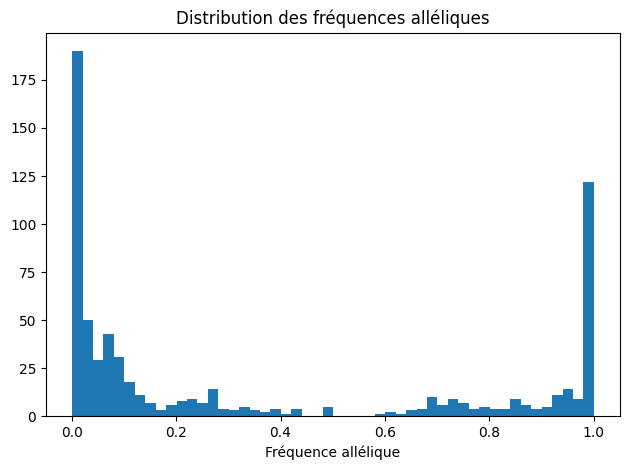

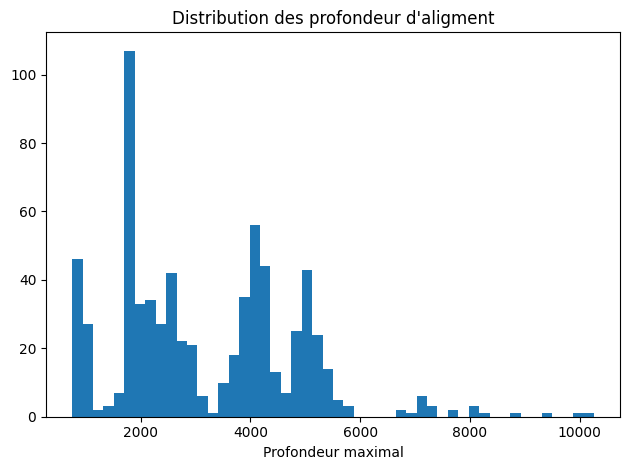

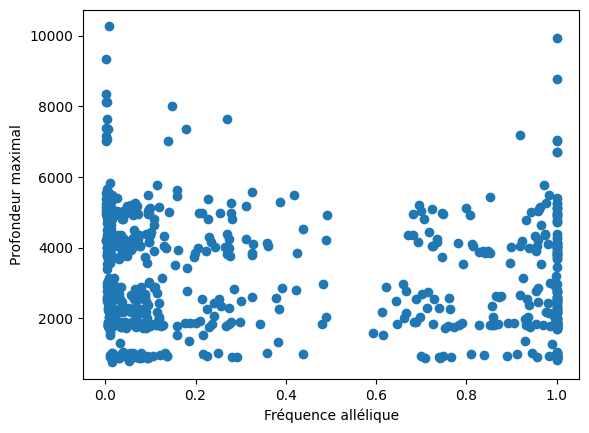

In [3]:
af = [v["af"] for v in all_variant]
depth = [max(v["depth"]) for v in all_variant]

fig, ax = plt.subplots()
ax.hist(af, bins=50)
ax.set_xlabel('Fréquence allélique')
ax.set_title("Distribution des fréquences alléliques")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.hist(depth, bins=50)
ax.set_xlabel('Profondeur maximal')
ax.set_title("Distribution des profondeur d'aligment")
fig.tight_layout()
plt.show()

# Fixing random state for reproducibility
np.random.seed(19680801)

x = np.random.rand(20)
y = 1e7 * np.random.rand(20)

fig, ax = plt.subplots()
plt.plot(af, depth, 'o')
ax.set_xlabel('Fréquence allélique')
ax.set_ylabel('Profondeur maximal')
plt.show()

### 1.3 Filtrage des variants basés sur une profondeur et une fréquence allélique minimum

- Pour la profondeur on considère la valeur max des différentes profondeurs fournis pour un même variant

In [4]:
min_depth = 500
min_freq = 0.2
data = [[v for v in d if v['af'] > min_freq and max(v['depth'])> min_depth] for d in data]

### 1.4 Distribution des type et des tailles de variants

- Les variants sont regroupé par similarité (\<thresold\> = proportion minimum de similarité), ceci pour l'ensemble total, l'ensemble chaud et l'ensemble froid
- La similarité entre 2 variants structurels est calculé d'après le nombre de base partagés (identiques à la même position) entre les 2
- Ainsi plusieurs occurences "similaires" d'un même variant ne sont compté qu'une fois

#### 1.4.1 Distribution des types

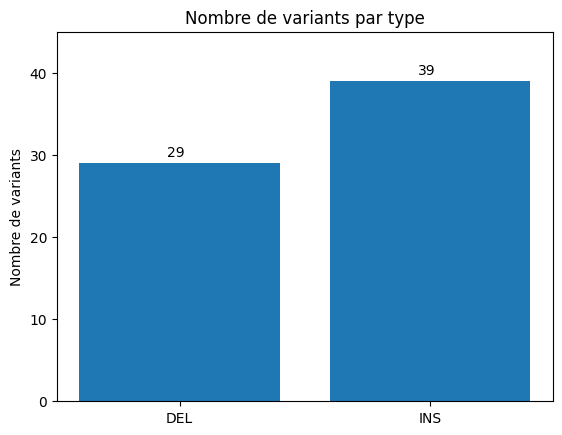

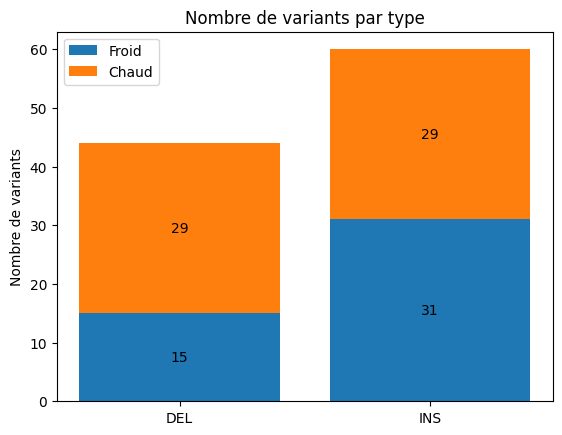

In [5]:
thresold = 1
all_variant_grouped = comp.merge_samples(data, sim_thresold=thresold)
cold_group_grouped = comp.merge_samples(data[0:5], sim_thresold=thresold)
heat_group_grouped = comp.merge_samples(data[5:10], sim_thresold=thresold)

counts_all = stats.count_types([grp[0][1]["svtype"] for grp in all_variant_grouped])
counts_cold = stats.count_types([grp[0][1]["svtype"] for grp in cold_group_grouped])
counts_heat = stats.count_types([grp[0][1]["svtype"] for grp in heat_group_grouped])

grouped_labels = list( set(counts_cold.keys()).union(counts_heat.keys()) )
grouped_counts = {
    "Froid": [counts_cold[k] if k in counts_cold else 0 for k in grouped_labels],
    "Chaud": [counts_heat[k] if k in counts_heat else 0 for k in grouped_labels],
}

stats.plot_count_by_type(counts_all)
stats.plot_grouped_count_by_type(grouped_counts, grouped_labels)

#### 1.4.2 Distribution de tailles par type, avec et sans outliers

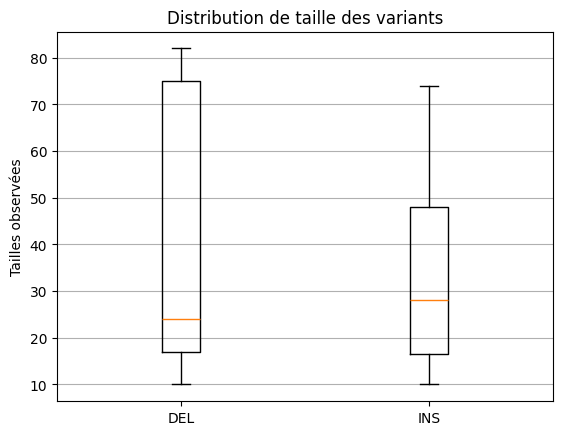

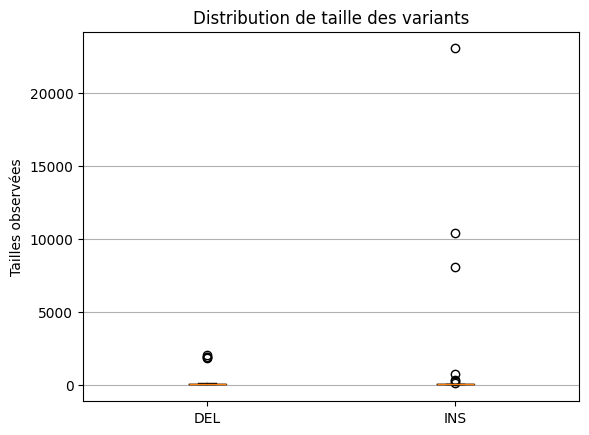

In [6]:
len_distrib_all = stats.len_by_type([(grp[0][1]["svtype"], np.mean([x[1]["svlen"] for x in grp])) for grp in all_variant_grouped])
stats.plot_len_by_type(len_distrib_all, False)
stats.plot_len_by_type(len_distrib_all, True)

### 1.5 Similarité par paire d'échantillon P90

- La case P90-4 / P90-5 par exemple affiche la proportion de variants partagé (similaires) entre ces deux échantillons

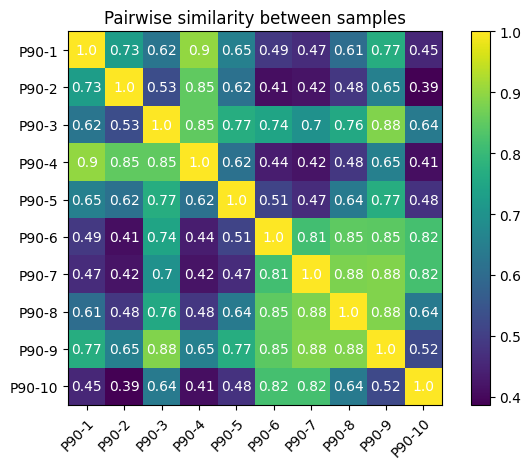

In [7]:
sims = comp.pairwise_similarity(list(range(0, 10)), all_variant_grouped)
comp.variant_heatmap(sims, [f"P90-{i}" for i in range(1, 11)])

### 1.6 Extraction des variants présent uniquement dans le chaud ou le froid

- On compte aussi le nombre d'occurence de chaque variant au travers des échantillons

In [8]:
only_cold = []
only_heat = []

for g in all_variant_grouped:
    present_in = 0
    counts = len(g)
    for v in g:
        if v[0] <= 4: # Groupe froid
            present_in = present_in | 1
        elif v[0] <= 9: # Groupe chaud
            present_in = present_in | 2
    
    if present_in == 1: # Groupe froid
        g[0][1]["n_found"] = counts
        only_cold.append(g[0][1])

    elif present_in == 2: # Groupd chaud
        g[0][1]["n_found"] = counts
        only_heat.append(g[0][1])

#### Variants trouvés uniquement dans le groupe froid

In [9]:
for c in only_cold:
    print(c)

{'pos': 37879, 'id': 'Sniffles2.INS.70S0', 'svtype': 'INS', 'svlen': 26, 'end': 37879, 'af': 0.671, 'depth': [4318.0, 4144.0, 4172.0, 4157.0, 4353.0], 'alt': [TGTGTGTGTGTGTGTGTGTGTGTGTG], 'n_found': 1}
{'pos': 37879, 'id': 'Sniffles2.INS.3BS0', 'svtype': 'INS', 'svlen': 28, 'end': 37879, 'af': 0.681, 'depth': [4881.0, 4668.0, 4683.0, 4688.0, 4959.0], 'alt': [TGTGTGTGTGTGTGTGTGTGTGTGTG], 'n_found': 1}
{'pos': 83046, 'id': 'Sniffles2.INS.FFS0', 'svtype': 'INS', 'svlen': 39, 'end': 83046, 'af': 0.234, 'depth': [4148.0, 4147.0, 4124.0, 4094.0, 4109.0], 'alt': [ACCAGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGC], 'n_found': 1}
{'pos': 83076, 'id': 'Sniffles2.INS.EDS0', 'svtype': 'INS', 'svlen': 48, 'end': 83076, 'af': 0.746, 'depth': [3694.0, 3725.0, 3687.0, 3639.0, 3637.0], 'alt': [CGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGACCAAACCCGACG], 'n_found': 1}
{'pos': 270829, 'id': 'Sniffles2.INS.33BS0', 'svtype': 'INS', 'svlen': 19, 'end': 270829, 'af': 0.8, 'depth': [4962.0, 4868.0, 5040.0, 5113.0, 5105.0], 'alt': [

#### Variants trouvés uniquement dans le groupe chaud

In [10]:
for h in only_heat:
    print(h)

{'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0], 'n_found': 1}
{'pos': 11384, 'id': 'Sniffles2.DEL.26BS0', 'svtype': 'DEL', 'svlen': -33, 'end': 11417, 'af': 1.0, 'depth': [3304.0, 3337.0, 3329.0, 3400.0, 3455.0], 'n_found': 5}
{'pos': 15501, 'id': 'Sniffles2.INS.35S0', 'svtype': 'INS', 'svlen': 12, 'end': 15501, 'af': 1.0, 'depth': [6742.0, 6831.0, 6910.0, 6939.0, 7022.0], 'alt': [TCATCATCATCA], 'n_found': 1}
{'pos': 16096, 'id': 'Sniffles2.DEL.1E5S0', 'svtype': 'DEL', 'svlen': -12, 'end': 16108, 'af': 0.616, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0], 'n_found': 1}
{'pos': 16098, 'id': 'Sniffles2.DEL.1E6S0', 'svtype': 'DEL', 'svlen': -20, 'end': 16118, 'af': 0.216, 'depth': [1356.0, 1431.0, 1473.0, 1482.0, 1536.0], 'n_found': 1}
{'pos': 21083, 'id': 'Sniffles2.DEL.1F3S0', 'svtype': 'DEL', 'svlen': -10, 'end': 21093, 'af': 0.383, 'depth': [1324.0, 1172.0, 1174.0, 1166.0, 1178.0

### 1.7 Variants exclusifs à chaque groupes, se trouvant dans une ORF

In [11]:
orfs = list_interval_with_dico()

print("Froids dans les ORFs : ")
for c in only_cold:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            found = found or (min(c["end"], int(inter[1])) - max(c["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", c)
            print()

print("Chauds dans les ORFs : ")
for h in only_heat:
    for orf in orfs:
        found = False
        for inter in orf["location"]:
            found = found or (min(h["end"], int(inter[1])) - max(h["pos"], int(inter[0])) > 0)
        if found:
            print(" ORF : ", orf)
            print(" Mutation : ", h)
            print()

Froids dans les ORFs : 
Chauds dans les ORFs : 
 ORF :  {'locus_tag': 'CyHV3_ORF5_1', 'protein_id': 'YP_001096044.1', 'location': [['8606', '9949']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 9457, 'id': 'Sniffles2.DEL.1D5S0', 'svtype': 'DEL', 'svlen': -17, 'end': 9474, 'af': 0.594, 'depth': [1572.0, 1551.0, 1499.0, 1489.0, 1399.0], 'n_found': 1}

 ORF :  {'locus_tag': 'CyHV3_ORF25', 'protein_id': 'YP_001096064.1', 'location': [['45570', '47375']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 47346, 'id': 'Sniffles2.DEL.2D2S0', 'svtype': 'DEL', 'svlen': -1850, 'end': 49196, 'af': 0.49, 'depth': [2047.0, 2004.0, 1989.0, 2004.0, 2034.0], 'n_found': 1}

 ORF :  {'locus_tag': 'CyHV3_ORF26', 'protein_id': 'YP_005352783.1', 'location': [['47474', '47644']], 'direct': True, 'complement': False, 'join': False}
 Mutation :  {'pos': 47346, 'id': 'Sniffles2.DEL.2D2S0', 'svtype': 'DEL', 'svlen': -1850, 'end': 49196, 'af': 0.49, 'depth': [2

## 2. Comparaison entre les itération d'un même échantillon (au fil du temps)

In [12]:
min_depth_it = 150
min_freq_it = 0.05

def plots_by_iteration(data_it, sample):
    labels_it = [f"P{it}-{sample}" for it in iterations]
    values_it = [len(d) for d in data_it]

    # Barplot
    fig, ax = plt.subplots()
    ax.bar(labels_it, values_it)
    ax.set_title(f'Nombre de variants dans chaque itération de l\'échantillon {sample}')
    ax.set_ylabel('Nombre de variants')
    plt.show()

    # Heatmap
    grouped_data_it = comp.merge_samples(data_it, sim_thresold=1)
    sims_it = comp.pairwise_similarity(list(range(0, 5)), grouped_data_it)
    comp.variant_heatmap(sims_it, [f"P{sample}-{i+1}" for i, sample in enumerate([15, 30, 50, 65, 90])])

### 2.1 Analyse de l'échantillon 1 (froid)

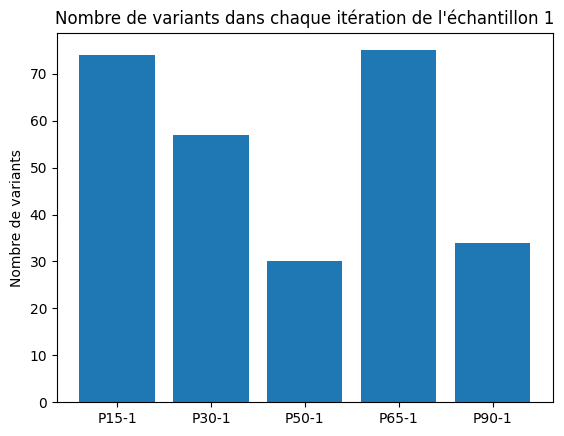

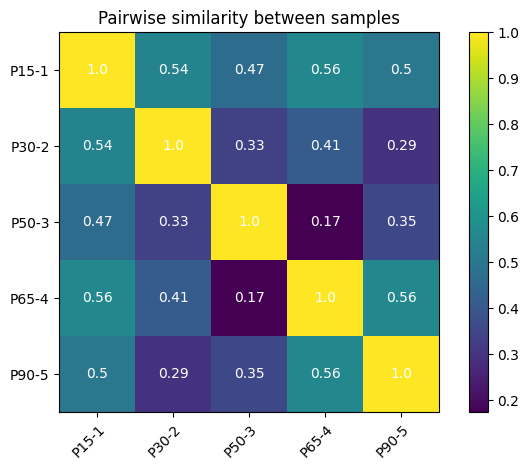

In [13]:
iterations = ["15", "30", "50", "65", "90"]

data_it_1 = [parse_vcf_noerror(f'data/data-p{i}/P{i}-1.trimed1000.sv_sniffles.vcf') for i in iterations]
data_it_1 = [[v for v in d if v['af'] > min_freq_it and max(v['depth']) > min_depth_it] for d in data_it_1]

plots_by_iteration(data_it_1, 1)

### 2.1 Analyse de l'échantillon 10 (chaud)

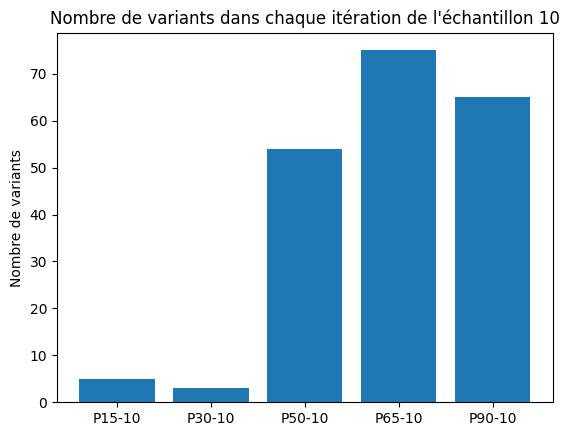

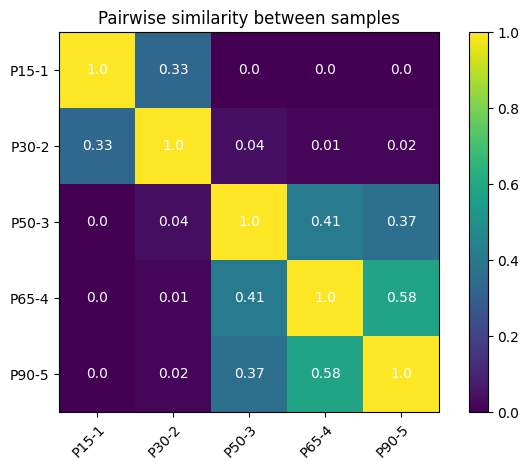

In [14]:
iterations = ["15", "30", "50", "65", "90"]

data_it_10 = [parse_vcf_noerror(f'data/data-p{i}/P{i}-10.trimed1000.sv_sniffles.vcf') for i in iterations]
data_it_10 = [[v for v in d if v['af'] > min_freq_it and max(v['depth']) > min_depth_it] for d in data_it_10]

plots_by_iteration(data_it_10, 10)